# Step 1: Parsing Files, Adding Candidates and Labels to Database

In [1]:
from __future__ import print_function
from __future__ import division
import json
# Loading config
with open("run_config.json") as fl:
    cfg = json.load(fl)
cfg_params = cfg['parameters']

# Setting snorkel path and output root
import os
from os.path import join
output_root = join(cfg_params['output_path'],cfg_params['experiment_name'])
os.environ['FONDUERDBNAME'] = cfg['postgres_db_name']
os.environ['SNORKELDB'] = join(cfg['postgres_location'],os.environ['FONDUERDBNAME'])

# For loading input files
import pandas as pd

# For running Snorkel
from snorkel.contrib.fonduer import SnorkelSession
from snorkel.contrib.fonduer.models import candidate_subclass
from snorkel.contrib.fonduer import HTMLPreprocessor, OmniParser
from utils import HTMLListPreprocessor

from sqlalchemy import create_engine
snorkeldb = create_engine(os.environ['SNORKELDB'], isolation_level="AUTOCOMMIT")

In [2]:
# Load labeled data from tsv
# Creating path to labeled data
pth_labeled = join(cfg['data_path'],'labels_and_splits')
# Getting labele data file name
fl_labeled = cfg['labeled_data_file']
# Loading labeled data into dataframe
df_labeled = pd.read_csv(join(pth_labeled,fl_labeled),sep='\t')
# Adding .html to filenames
# NOTE: Need to add .html to all actual filenames before running
path_list_labeled = [_+'.html' for _ in df_labeled['file name'].tolist()]

#Load unlabeled data from tsv
fl_unlabeled = cfg['unlabeled_data_file']
df_unlabeled = pd.read_csv(join(pth_labeled,fl_unlabeled),sep='\t')
path_list_unlabeled = [_+'.html' for _ in df_unlabeled['file name'].tolist()]

# Start snorkel session and creating location subclass
session = SnorkelSession()
Location_Extraction = candidate_subclass('location_extraction',\
                          ["location"])

## Parsing Documents

In [3]:
# Getting parameter for max number of docs to load from labeled/unlabeled
max_docs = cfg['max_docs']

# Setting location for raw data
data_loc = join(cfg['data_path'],'raw_data')

# Creating a list of paths for documents from both labeled and unlabeled data
path_list = path_list_labeled[:max_docs]+path_list_unlabeled[:max_docs]

# Preprocessing documents from path_list
doc_preprocessor = HTMLListPreprocessor(data_loc,\
                                file_list=path_list)

# Ingest data into Fonduer via parser
corpus_parser = OmniParser(structural=True, lingual=True, visual=False)
%time corpus_parser.apply(doc_preprocessor, parallelism=cfg['parallel'])

Clearing existing...
Running UDF...


Warning, empty document 018563ac-eb50-4d26-8507-31e9cf836999 passed to CoreNLPWarning, empty document 0620fe76-98ce-4add-9371-e4a752446e12 passed to CoreNLPWarning, empty document 14151fbd-febd-4602-b86d-0bf210b38963 passed to CoreNLPWarning, empty document 1714fcc6-d9d1-4f32-b80c-d25203bcbe2f passed to CoreNLPWarning, empty document 1714fcc6-d9d1-4f32-b80c-d25203bcbe2f passed to CoreNLPWarning, empty document 1714fcc6-d9d1-4f32-b80c-d25203bcbe2f passed to CoreNLPWarning, empty document 1714fcc6-d9d1-4f32-b80c-d25203bcbe2f passed to CoreNLPWarning, empty document 1714fcc6-d9d1-4f32-b80c-d25203bcbe2f passed to CoreNLPWarning, empty document 1714fcc6-d9d1-4f32-b80c-d25203bcbe2f passed to CoreNLPWarning, empty document 1714fcc6-d9d1-4f32-b80c-d25203bcbe2f passed to CoreNLPWarning, empty document 1714fcc6-d9d1-4f32-b80c-d25203bcbe2f passed to CoreNLPWarning, empty document 1714fcc6-d9d1-4f32-b80c-d25203bcbe2f passed to CoreNLPWarning, empty document 1714fcc6-d9d1-4f32-b80c-d25203bcbe2f pas

CPU times: user 1.79 s, sys: 101 ms, total: 1.9 s
Wall time: 1min 52s


In [4]:
from snorkel.contrib.fonduer.models import Document, Phrase

# Checking database contents
print("Documents:", session.query(Document).count())
print("Phrases:", session.query(Phrase).count())

Documents: 60
Phrases: 36426


# Step 2: Dividing into Test/Train, Extracting Features, Throttling

In [5]:
# Getting all documents parsed by Fonduer
docs = session.query(Document).order_by(Document.name).all()
ld   = len(docs)

# Setting up train, dev, and test sets
train_docs = set()
dev_docs   = set()
test_docs  = set()

# Creating list of (document name, Fonduer document object) tuples
data = [(doc.name+'.html', doc) for doc in docs]
data.sort(key=lambda x: x[0])

# Adding unlabeled data to train set, 
# labaled data to dev/test sets in alternating fashion
for i, (doc_name, doc) in enumerate(data):
    if doc_name in path_list_unlabeled:
        train_docs.add(doc)
    else:
        if len(dev_docs)<=len(test_docs):
            dev_docs.add(doc)
        else:
            test_docs.add(doc)

#Printing length of train/test/dev sets
print("train:",len(train_docs))
print("dev:" ,len(dev_docs))
print("test:",len(test_docs))

#Printing some filenames 
from pprint import pprint
pprint([x.name for x in train_docs])
pprint([x.name for x in dev_docs])
pprint([x.name for x in test_docs])

train: 30
dev: 15
test: 15
[u'0726934f-a54c-402c-9d35-2dad34ef6cc0',
 u'08cd0eea-86a7-40a3-b8e7-1500c33edec5',
 u'070cd8d8-3133-4f1e-9c54-bdaeab3116da',
 u'07998afe-1494-4b87-9c20-a213b4fb29f5',
 u'03be9e25-a022-4269-9164-7033e2564304',
 u'0582d3b3-90d9-4ecb-8603-c389d952cc63',
 u'0b40c6df-dffd-45b1-87fe-8d0c7a4acbf5',
 u'06370eb0-2ad4-4f4d-b176-18d1fd07ac0a',
 u'079c559f-f8c1-4665-baec-20077dc97a0e',
 u'001a5f8b-82c5-4428-b539-0c8a0f2f87c4',
 u'0658b927-cb6b-407e-ba8f-e83d8e42e458',
 u'069da521-9287-476c-a4a5-71744fafe2bd',
 u'0ae80b59-b5e5-411e-8c90-e5e1719bf20e',
 u'0034ff21-5d7a-4edf-9150-e22c5188dde1',
 u'08e75d28-5190-46f4-b114-36076aede6dd',
 u'005dd27d-91c5-4569-b285-489391dcff4f',
 u'09702fd4-adf0-48ba-8af8-1a315f4c7489',
 u'02663026-4377-4c61-a19e-907e81e74ce0',
 u'0166a90b-5733-4336-88a0-b5a48fcb14fd',
 u'066e1a68-9f65-4a4e-a156-8cafa6f7a6d4',
 u'0aee8140-f207-4b54-9c9b-cb97fb296c5e',
 u'0189ca4e-f259-4bf3-8144-0e4fa64620e0',
 u'0656355c-45c3-47fd-a3bc-2a0a6971fc5e',
 u'0686

In [6]:
#Importing matchers module and defining LocationMatcher
from snorkel.matchers import *
location_matcher = LocationMatcher(longest_match_only=True) 

#importing NGrams and defining location_ngrams 
from snorkel.contrib.fonduer.fonduer.candidates import OmniNgrams
location_ngrams = OmniNgrams(n_max=6, split_tokens=[])

In [7]:
from snorkel.contrib.fonduer.lf_helpers import *
import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

# Creating filter to eliminate mentions of currency  
def location_currencies_filter(location):
    list_currencies = [ "dollar", "dollars", "lira","kwacha","rials","rial","dong","dongs","fuerte","euro",
                       "euros","vatu","som","peso","sterling","sterlings","soms","pestos",
                       "pounds", 
                  "pound","dirham","dirhams","hryvnia","manat","manats","liras","lira",
                       "dinar","dinars","pa'anga","franc","baht","schilling",
                  "somoni","krona","lilangeni","rupee","rand","shilling","leone","riyal","dobra",
                  "tala","ruble","zloty","peso","sol","quarani","kina","guinean","balboa","krone","naira",
                  "cordoba","kyat","metical","togrog","leu","ouguiya","rufiyaa","ringgit","kwacha",
                  "ariary","denar","litas","loti","lats","kip","som","won","tenge","yen","shekel","rupiah",
                  "forint","lempira","gourde","quetzal","cedi","lari","dalasi","cfp","birr","kroon","nakfa",
                  "cfa","Peso","koruna","croatian","colon","yuan","escudo","cape","riel","lev","real"
                  ,"real","mark","boliviano","ngultrum","taka","manat","dram","kwanza","lek","afghani","renminbi"]

    
    cand_right_tokens = list(get_right_ngrams(location,window=2))
    for cand in cand_right_tokens:
        if cand not in list_currencies:
            return location

# Setting candidate filter to location_currencies_filter
candidate_filter = location_currencies_filter

In [8]:
from snorkel.contrib.fonduer.candidates import CandidateExtractor

# Defining candidate extractor
candidate_extractor = CandidateExtractor(Location_Extraction,
                                         [location_ngrams], [location_matcher],
                                         candidate_filter=candidate_filter)

# Extracting candidates from each split
%time candidate_extractor.apply(train_docs, split=0, parallelism=cfg['parallel'])
print("Number of candidates:", session.query(Location_Extraction).filter(Location_Extraction.split == 0).count())
%time
for i, docs in enumerate([dev_docs, test_docs]):
    candidate_extractor.apply(docs, split=i+1, parallelism=cfg['parallel'])
    print("Number of candidates:", session.query(Location_Extraction).filter(Location_Extraction.split == i+1).count())

Clearing existing...
Running UDF...
CPU times: user 29.2 ms, sys: 32.1 ms, total: 61.3 ms
Wall time: 6.29 s
Number of candidates: 64
CPU times: user 6 µs, sys: 6 µs, total: 12 µs
Wall time: 17.9 µs
Clearing existing...
Running UDF...
Number of candidates: 121
Clearing existing...
Running UDF...
Number of candidates: 96


In [ ]:
# Testing sandbox for candiates
from snorkel.contrib.fonduer.models import Document, Phrase
ind = 1
#cands = session.query(Location_Extraction).filter(Location_Extraction.split == 1).order_by(Location_Extraction).all()
cands = session.query(Document).filter(Document.name=='05013466-0148-4daf-9842-8375bffdcaa9').all()
# cand = cands[ind]
# args = cand.get_contexts()
# span = args[0]
# c = span.sentence.is_lingual()
# a = span.get_parent()
# print(span)
# print(cand[0].sentence.document.name)
# print(cand[0].get_span())
# print('>' in cand[0].get_parent().text)
# print (cand[0].get_parent().text)
# print (get_attributes(cand[0]))
cands[0].text

In [9]:
# Applying the featurizer (to get feature vector describing the input)
from snorkel.contrib.fonduer import BatchFeatureAnnotator
session.rollback()
featurizer = BatchFeatureAnnotator(Location_Extraction)
# Running for train set -- replace_key_set = True!
%time F_train = featurizer.apply(split=0, replace_key_set=True, parallelism=cfg['parallel'])
session.rollback()
print(F_train.shape)
# Running for dev set -- replace_key_set = False! Uses same featuers as dev set
%time F_dev = featurizer.apply(split=1, replace_key_set=False, parallelism=cfg['parallel'])
session.rollback()
print(F_dev.shape)
%time F_test = featurizer.apply(split=2, replace_key_set=False, parallelism=cfg['parallel'])
session.rollback()
print(F_test.shape)

Clearing existing...
Running UDF...
Copying location_extraction_feature_updates to postgres
COPY 64

CPU times: user 57.3 ms, sys: 37.7 ms, total: 95.1 ms
Wall time: 4.84 s
(64, 1393)
Clearing existing...
Running UDF...
Copying location_extraction_feature_updates to postgres
COPY 121

CPU times: user 64.5 ms, sys: 35.6 ms, total: 100 ms
Wall time: 4.81 s
(121, 1393)
Clearing existing...
Running UDF...
Copying location_extraction_feature_updates to postgres
COPY 96

CPU times: user 58.2 ms, sys: 39.3 ms, total: 97.6 ms
Wall time: 5 s
(96, 1393)


# Step 3: Adding Gold Labels

In [13]:
from builtins import range
import csv
import codecs

from snorkel.utils import ProgressBar
from snorkel.models import GoldLabel, GoldLabelKey

# Defining function for getting gold labels
# Could go in utils file later!
def load_chtap_labels(session, candidate_class, df, target, annotator_name='gold'):
    
    # Database nonsense to make sure that there is a "gold" annotator 
    ak = session.query(GoldLabelKey).filter(GoldLabelKey.name == annotator_name).first()
    if ak is None:
        ak = GoldLabelKey(name=annotator_name)
        session.add(ak)
        session.commit()   
    
    # Getting all candidates from dev/test set only (splits 1 and 2)
    candidates = session.query(candidate_class).filter(candidate_class.split != 0).all()
    cand_total = len(candidates)
    print('Loading', cand_total, 'candidate labels')
    pb = ProgressBar(cand_total)
    labels=[]
    
    # For each candidate, add appropriate gold label
    for i, c in enumerate(candidates):
        pb.bar(i)
        # Get document name for candidate
        doc = c[0].sentence.document.name
        # Get text span for candidate
        val = c[0].get_span().lower()
        # Get location label from labeled dataframe (input)
        target_strings = df[df['file name']==doc][target].tolist()
        # Handling location extraction
        if target == 'location':
                if target_strings == []:
                    targets = ''
                else:
                    targets = target_strings[0].lower().split(',')
        # Keeping this in comments...don't know what it was for
        #context_stable_ids = '~~'.join([i.stable_id for i in c.get_contexts()])
        label = session.query(GoldLabel).filter(GoldLabel.key == ak).filter(GoldLabel.candidate == c).first()
        if label is None:
            # Matching target label string to extract span, adding TRUE label if found, FALSE if not
            # This conditional could be improved (use regex, etc.)
            if val in targets or any([a in val for a in targets]):
                label = GoldLabel(candidate=c, key=ak, value=1)
            else:
                label = GoldLabel(candidate=c, key=ak, value=-1)
            session.add(label)
            labels.append(label)
    session.commit()
    pb.close()

    session.commit()
    print("AnnotatorLabels created: %s" % (len(labels),))

In [14]:
# Adding gold labels to database
session.rollback()
target = 'location'
load_chtap_labels(session, Location_Extraction, df_labeled, target ,annotator_name='gold')

Loading 217 candidate labels
[========================================] 100%
AnnotatorLabels created: 0


In [18]:
# Check class balance on dev/test
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
print('Dev Set Balance: %0.2f Percent Positive' % (100*np.sum(L_gold_dev == 1)/L_gold_dev.shape[0]))
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
print('Test Set Balance: %0.2f Percent Positive' % (100*np.sum(L_gold_test == 1)/L_gold_test.shape[0]))

Dev Set Balance: 32.23 Percent Positive
Test Set Balance: 37.50 Percent Positive


# Step 4: Creating LFs

In [19]:
 cand_dev =session.query(Location_Extraction).filter(Location_Extraction.split == 1).all()

In [20]:
# Helper functions for true/false/abstain
TRUE,FALSE,ABSTAIN = 1,-1,0

In [46]:
from snorkel.contrib.fonduer.lf_helpers import *

# Defining LFs
# LF API is here: http://web.stanford.edu/~lwhsiao/api/

#def LF_in_breadcrumbs_1(c):
#    parent_text = c.get_parent().text
#    return TRUE if '>' in parent_text else ABSTAIN

def LF_in_breadcrumbs_2(c):
    attributes = list(get_attributes(c))
    return TRUE if ('class=breadcrumbs'in attributes) or ('class=inside_scroll' in attributes) else ABSTAIN

def LF_head_in_tag(c):
    tags = list(get_ancestor_tag_names(c))
    return FALSE if 'head' in tags else TRUE

def LF_body_in_tag(c):
    tags = list(get_ancestor_tag_names(c))
    return TRUE if 'body' in tags else FALSE

def LF_table_in_tag(c):
    tags = list(get_ancestor_tag_names(c))
    return TRUE if 'table' in tags else ABSTAIN

#def LF_to_left(c):
#    return TRUE if overlap(
#      ['location','locall','outcall','stay','live','available','female escort'], 
#        get_left_ngrams(c, window=3)) else FALSE

def LF_to_right(c):
    return TRUE if overlap(
      ['escorts','incall','outcall','stay','live','available','female escort'], 
        list(get_right_ngrams(c, window=5))) else ABSTAIN
# Need more of these...can check tutorials for inspiration

In [47]:
# API function sandbox
from snorkel.contrib.fonduer.lf_helpers import *
get_ancestor_tag_names(cand_dev[0])
for i,cand in enumerate(cand_dev[:15]):
    print (i,get_attributes(cand),LF_in_breadcrumbs_2(cand))

0 [] 0
1 [u'class=inside_scroll'] 1
2 [u'type=text/javascript'] 0
3 [u'href=/texas/dallas/female-escorts/', u'title=Dallas, Texas Female Escort'] 0
4 [u'class=breadcrumbs'] 1
5 [u'href=/texas/dallas/female-escorts/', u'title=Dallas, Texas Female Escort'] 0
6 [u'class=breadcrumbs'] 1
7 [] 0
8 [u'class=summary'] 0
9 [] 0
10 [u'class=breadcrumbs'] 1
11 [u'class=contactmeta', u'style=margin-top:0;font-weight:normal;font-size:-10%;'] 0
12 [u'class=inside_scroll'] 1
13 [u'class=meta'] 0
14 [u'class=inside_scroll'] 1


In [49]:
### Test Cell
from snorkel.contrib.fonduer.lf_helpers import *
import re
# if list(get_right_ngrams(cand_dev[0], window=3, attrib='words', n_min=1, n_max=1, lower=True))=="escorts":
#     print("hi")
# else:
#     print("no") 
#list(get_right_tokens(cand_dev[0], window=3))


# def LF_to_left(c):
#     return 1 if 'escorts' in get_right_ngrams(c, window=2) else 0

# def LF_to_right(c):
#     return 1 if overlap(
#       ['escorts','incall','outcall','stay','live','available','female escort','female escorts','female escort'], 
#         list(get_right_ngrams(c, window=5)) else 0
# def LF_to_left(c):
#     return 1 if overlap(
#       ['location','locall','outcall','stay','live','available','female escort','place','located in'], 
#         list(get_left_ngrams(c, window=2)))) else 0
# LF_to_left(cand_dev[0])
#LF_to_left(cand_dev[0])
#print (cands)
# get_attributes(cand_dev[1])

SyntaxError: invalid syntax (<ipython-input-49-5b578335d891>, line 17)

In [50]:
# Collect LFs in list
lfs_location = [#LF_in_breadcrumbs_1
                LF_in_breadcrumbs_2,
                LF_head_in_tag,
                LF_body_in_tag,
                LF_to_right,
                #LF_to_left,
                LF_table_in_tag,]
print (lfs_location)

[<function LF_in_breadcrumbs_2 at 0x12e33b578>, <function LF_head_in_tag at 0x12d0980c8>, <function LF_body_in_tag at 0x12e33baa0>, <function LF_to_right at 0x12e33b320>, <function LF_table_in_tag at 0x12e33b5f0>]


# Step 5: Running Generative Model

In [51]:
from snorkel.contrib.fonduer import BatchLabelAnnotator

# Annotating candidats using LFs (clear=True replaced existing)
labeler = BatchLabelAnnotator(Location_Extraction, lfs=lfs_location)
%time L_train = labeler.apply(split=0, clear=True, parallelism=cfg['parallel'],update_keys =True)
%time L_dev = labeler.apply(split=1, clear=True, parallelism=cfg['parallel'],update_keys =True)
%time L_test = labeler.apply(split=2, clear=True, parallelism=cfg['parallel'],update_keys =True)
print(L_dev.shape)

Clearing existing...
Running UDF...
Copying location_extraction_label_updates to postgres
COPY 64

CPU times: user 29.3 ms, sys: 56.2 ms, total: 85.5 ms
Wall time: 4.1 s
Clearing existing...
Running UDF...
Copying location_extraction_label_updates to postgres
COPY 121

CPU times: user 31.3 ms, sys: 47.3 ms, total: 78.6 ms
Wall time: 3.99 s
Clearing existing...
Running UDF...
Copying location_extraction_label_updates to postgres
COPY 96

CPU times: user 29 ms, sys: 46.7 ms, total: 75.7 ms
Wall time: 4.03 s
(121, 8)


#### 5.a)Computing Individual LF Statistics

In [27]:
def coverage_LF(lf, split, gold=None):
    labeled = []
    #session.query(Location_Extraction).filter(Location_Extraction.split == split
    cands = session.query(Location_Extraction).filter(Location_Extraction.split == split).all()
    for i,c in enumerate(cands):
        if lf(c) != 0:
            if gold != None and gold.size != 0:
                labeled.append((c, gold[i,0]))
            else:
                labeled.append(c)
    print ("{} labeled candidates: {}".format(lf.__name__, len(labeled)))
    return labeled

In [28]:
labeled = coverage_LF(LF_in_breadcrumbs_2, 1)

LF_in_breadcrumbs_2 labeled candidates: 11


In [29]:
from snorkel.lf_helpers import test_LF
for lf in lfs_location:
    print(lf.__name__)
    tp, fp, tn, fn = test_LF(session, lf, split=1, annotator_name='gold')

LF_in_breadcrumbs_2
Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.455
Recall               1.0
F1                   0.625
----------------------------------------
TP: 5 | FP: 6 | TN: 0 | FN: 0

LF_head_in_tag
Scores (Un-adjusted)
Pos. class accuracy: 0.872
Neg. class accuracy: 0.659
Precision            0.548
Recall               0.872
F1                   0.673
----------------------------------------
TP: 34 | FP: 28 | TN: 54 | FN: 5

LF_body_in_tag
Scores (Un-adjusted)
Pos. class accuracy: 0.872
Neg. class accuracy: 0.659
Precision            0.548
Recall               0.872
F1                   0.673
----------------------------------------
TP: 34 | FP: 28 | TN: 54 | FN: 5

LF_to_right
Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.789
Recall               1.0
F1                   0.882
----------------------------------------
TP: 15 | FP: 4 | TN: 0 | FN: 0

LF_table_in_tag
Scores (Un-adju

In [31]:
# Showing a candidate from dev set
L_dev.get_candidate(session, 1)

location_extraction(Span("Texas", sentence=129589, chars=[7,11], words=[2,2]))

In [32]:
# Loading assessing LF performance vs. gold labels
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
%time L_dev.lf_stats(L_gold_dev)

CPU times: user 21.1 ms, sys: 16 µs, total: 21.1 ms
Wall time: 21.1 ms


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_head_in_tag,0,1.000000,1.000000,0.024793,34,28,5,54,0.727273
LF_in_breadcrumbs_1,1,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_in_breadcrumbs_2,2,0.090909,0.090909,0.000000,5,6,0,0,0.454545
LF_body_in_tag,3,1.000000,1.000000,0.024793,34,28,5,54,0.727273
LF_in_breadcrumbs,4,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_to_right,5,0.157025,0.157025,0.024793,15,4,0,0,0.789474
LF_table_in_tag,6,0.033058,0.033058,0.000000,4,0,0,0,1.000000
LF_to_left,7,0.000000,0.000000,0.000000,0,0,0,0,NaN


In [33]:
from snorkel.learning import GenerativeModel

# Running the generative model
# TODO: Add hyperparameter search 
gen_model = GenerativeModel()
%time gen_model.train(L_train, epochs=5000, decay=0.9, step_size=0.001, reg_param=0)

Inferred cardinality: 2
CPU times: user 8.32 s, sys: 42.1 ms, total: 8.36 s
Wall time: 8.41 s


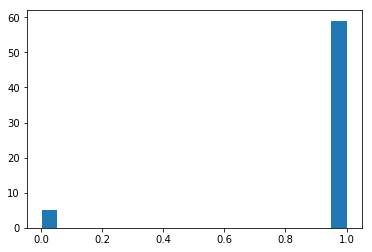

In [34]:
# Importing and plotting training marginals
train_marginals = gen_model.marginals(L_train)
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [35]:
# Printing LF accuracies
gen_model.weights.lf_accuracy

array([ 1.45192642,  0.45071429,  0.95850357,  1.42013713,  0.44181012,
        1.25960084,  0.45956758,  0.45825028])

In [36]:
# Pringint LF stats post-learning
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
prec, rec, f1 = gen_model.score(L_dev, L_gold_dev)
L_dev.lf_stats(L_gold_dev, gen_model.weights.lf_accuracy)

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_head_in_tag,0,1.000000,1.000000,0.024793,34,28,5,54,0.727273,1.451926
LF_in_breadcrumbs_1,1,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.450714
LF_in_breadcrumbs_2,2,0.090909,0.090909,0.000000,5,6,0,0,0.454545,0.958504
LF_body_in_tag,3,1.000000,1.000000,0.024793,34,28,5,54,0.727273,1.420137
LF_in_breadcrumbs,4,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.441810
LF_to_right,5,0.157025,0.157025,0.024793,15,4,0,0,0.789474,1.259601
LF_table_in_tag,6,0.033058,0.033058,0.000000,4,0,0,0,1.000000,0.459568
LF_to_left,7,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.458250


In [37]:
from snorkel.learning import SparseLogisticRegression
# Running discriminative model to predict generative model marginals from 
# features output from featurizer
disc_model = SparseLogisticRegression()
%time disc_model.train(F_train, train_marginals, n_epochs=200, lr=0.001)

[SparseLogisticRegression] Training model
[SparseLogisticRegression] n_train=64  #epochs=200  batch size=64
[SparseLogisticRegression] Epoch 0 (0.06s)	Average loss=0.850676
[SparseLogisticRegression] Epoch 5 (0.08s)	Average loss=0.740112
[SparseLogisticRegression] Epoch 10 (0.10s)	Average loss=0.640737
[SparseLogisticRegression] Epoch 15 (0.13s)	Average loss=0.553099
[SparseLogisticRegression] Epoch 20 (0.15s)	Average loss=0.477167
[SparseLogisticRegression] Epoch 25 (0.17s)	Average loss=0.412364
[SparseLogisticRegression] Epoch 30 (0.19s)	Average loss=0.357701
[SparseLogisticRegression] Epoch 35 (0.22s)	Average loss=0.311949
[SparseLogisticRegression] Epoch 40 (0.24s)	Average loss=0.273808
[SparseLogisticRegression] Epoch 45 (0.27s)	Average loss=0.242025
[SparseLogisticRegression] Epoch 50 (0.29s)	Average loss=0.215479
[SparseLogisticRegression] Epoch 55 (0.31s)	Average loss=0.193206
[SparseLogisticRegression] Epoch 60 (0.33s)	Average loss=0.174405
[SparseLogisticRegression] Epoch 65 

In [38]:
# Evaluate discriminative on test set 
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

In [ ]:
L_train.shape


In [58]:
# Get candidates, discriminative model outputs, and discriminative model predicts
test_candidates = [F_test.get_candidate(session, i) for i in range(F_test.shape[0])]
test_score = disc_model.predictions(F_test)
true_pred = [test_candidates[_] for _ in np.nditer(np.where(test_score > 0))]

print(test_score)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1 -1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1  1  1  1 -1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1  1 -1  1  1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1]


In [59]:
#L_gold_test
corr = test_score == L_gold_test
acc = np.sum(corr)/len(corr)
print (acc)

45.5
